<a href="https://colab.research.google.com/github/viacheslav-konstantinov/MADE2019_MOML/blob/master/HW6/HW6_Konstantinov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание №6. Метод Ньютона.  Квазиньютоновские методы (практическая часть)

## Вячеслав Константинов

## 0 Подключение необходимых библиотек и файлов

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PATH = "./drive/My Drive/Colab Notebooks/MADE2019/MOML/HW6"
os.chdir(PATH)

In [3]:
!ls -l

total 1372
drwx------ 2 root root    4096 May 30 18:10 datasets
drwx------ 2 root root    4096 May 30 18:10 dump
-rw------- 1 root root     136 May 31 20:19 f_star_a9a.npy
-rw------- 1 root root     136 May 31 20:24 f_star_gisette.npy
-rw------- 1 root root     136 May 31 20:24 f_star_real_sim.npy
-rw------- 1 root root 1154596 May 31 20:44 HW6_Konstantinov.ipynb
-rw------- 1 root root   11186 May 31 15:07 methods.py
-rw------- 1 root root    3570 May 30 15:58 oracles.py
drwx------ 2 root root    4096 May 30 18:17 __pycache__
-rw------- 1 root root   10317 May 30 13:58 tests.py
-rw------- 1 root root    1112 May 31 20:19 x_star_a9a.npy
-rw------- 1 root root   40128 May 31 20:24 x_star_gisette.npy
-rw------- 1 root root  167792 May 31 20:24 x_star_real_sim.npy


In [4]:
!pip install nose

In [0]:
from methods import *
from tests import *
from oracles import *

import matplotlib
from matplotlib import pyplot as plt

from sklearn.datasets import load_svmlight_file
from pathlib import Path
import pickle
from scipy.sparse.linalg import svds
from numpy.linalg import norm

%matplotlib inline

In [0]:
def prepare_data(dataset):
    filename = "datasets/" + dataset + ".txt"

    data = load_svmlight_file(filename)
    A, y = data[0], data[1]
    m, n = A.shape
    
    if (2 in y) & (1 in y):
        y = 2 * y - 3
    if (2 in y) & (4 in y):
        y = y - 3
    assert((-1 in y) & (1 in y))
    
    sparsity_A = A.count_nonzero() / (m * n)
    return A, y, m, n, sparsity_A

## 1. Имплементация методов

## 1.1 Метод Ньютона

In [0]:
test_newton = TestNewton()

#тесты реализации метода Ньютона
test_newton.test_newton_ideal_step()
test_newton.test_newton_1d()

## 1.2 BFGS

In [0]:
test_bfgs = TestBFGS()

#тесты реализации BFGS
test_bfgs.test_default()
test_bfgs.test_tolerance()
test_bfgs.test_max_iter()
test_bfgs.test_line_search_options()
test_bfgs.test_quality()

## 1.3 L-BFGS

In [0]:
test_lbfgs = TestLBFGS()

#тесты реализации L-BFGS
test_lbfgs.test_default()
test_lbfgs.test_tolerance()
test_lbfgs.test_max_iter()
test_lbfgs.test_memory_size()
test_lbfgs.test_history()
test_lbfgs.test_quality()
test_lbfgs.test_line_search_options()

## 2. Точные решения и "правильные" графики

## 2.1 Датасет $\texttt{a9a}$ 

In [10]:
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)

Число функций в сумме:  32561 , размерность задачи:  123


In [0]:
a9a_oracle = create_log_reg_oracle(A, y, 1/m)
grad0 = a9a_oracle.grad(-np.ones(n)).T @ a9a_oracle.grad(-np.ones(n))
lbfgs_a9a = LBFGS(oracle=a9a_oracle, x_0=-np.ones(n), tolerance=1e-16/grad0)

In [12]:
%%time
lbfgs_a9a.run(5000)
print("number of iterations", len(lbfgs_a9a.hist['grad_norm']))

number of iterations 510
CPU times: user 7.82 s, sys: 5.73 ms, total: 7.83 s
Wall time: 7.84 s


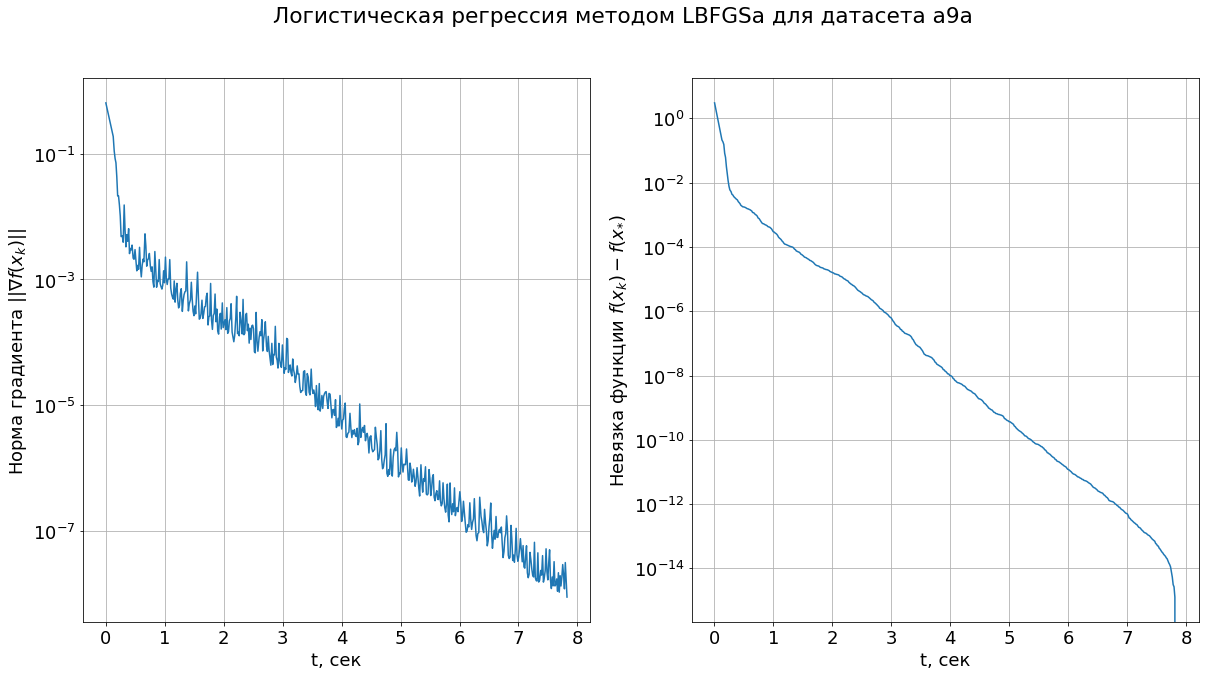

In [13]:
matplotlib.rcParams.update({'font.size': 18})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), )

f_star_a9a = a9a_oracle.func(lbfgs_a9a.hist['x_star'])
x_star_a9a = lbfgs_a9a.hist['x_star']

title = "Логистическая регрессия методом LBFGSа для датасета " + dataset
fig.suptitle(title)

ax1.plot(lbfgs_a9a.hist['time'], lbfgs_a9a.hist['grad_norm'])
ax1.grid()
ax1.semilogy()
ax1.set_xlabel("t, сек")
ax1.set_ylabel(r"Норма градиента $|| \nabla f(x_k) ||$")

ax2.plot(lbfgs_a9a.hist['time'],  lbfgs_a9a.hist['func'] - f_star_a9a)
ax2.grid()
ax2.semilogy()
ax2.set_xlabel("t, сек")
ax2.set_ylabel(r"Невязка функции $f(x_k) - f(x_{*})$")

plt.show()

In [0]:
np.save("f_star_a9a.npy", f_star_a9a)
np.save("x_star_a9a.npy", x_star_a9a)

## 2.2 Датасет $\texttt{gisette}$

In [15]:
dataset = "gisette"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)

Число функций в сумме:  6000 , размерность задачи:  5000


In [0]:
gisette_oracle = create_log_reg_oracle(A, y, 1/m)
grad0 = gisette_oracle.grad(-np.ones(n)).T @ gisette_oracle.grad(-np.ones(n))
lbfgs_gisette = LBFGS(oracle=gisette_oracle, 
                      x_0=-np.ones(n), 
                      tolerance=1e-16/grad0, 
                      memory_size=50)

In [17]:
%%time
lbfgs_gisette.run(5000)
print("number of iterations", len(lbfgs_gisette.hist['grad_norm']))

number of iterations 215
CPU times: user 1min 52s, sys: 18.7 ms, total: 1min 52s
Wall time: 1min 53s


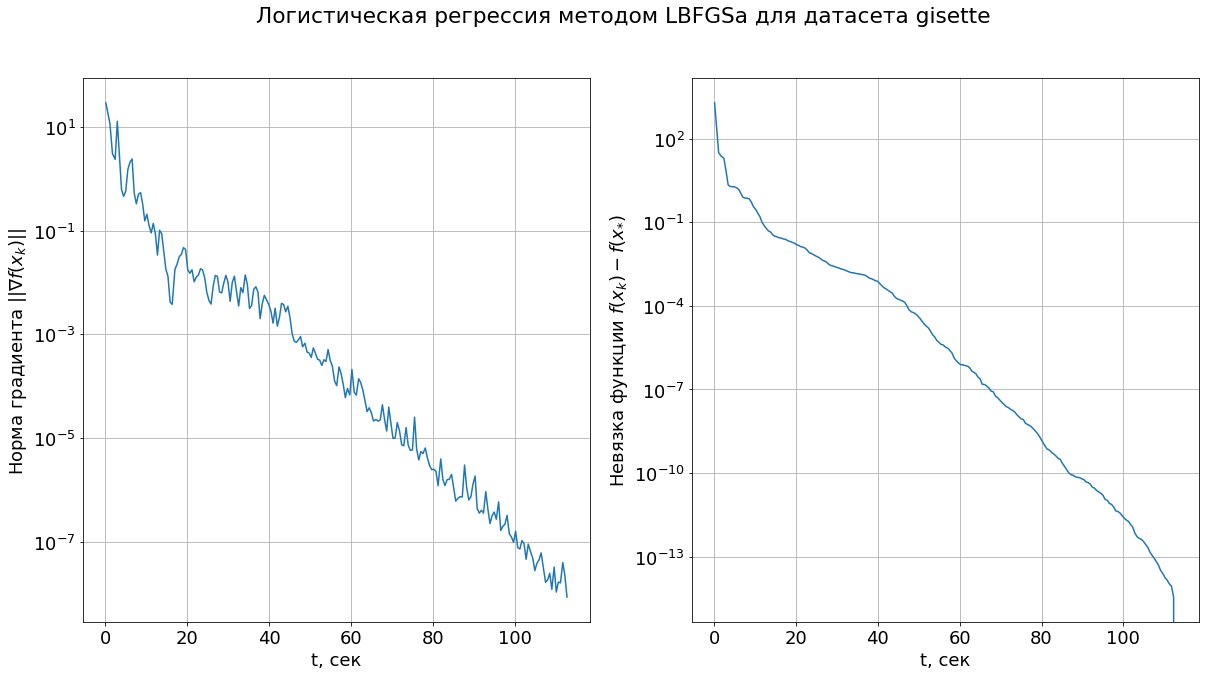

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), )

f_star_gisette = gisette_oracle.func(lbfgs_gisette.hist['x_star'])
x_star_gisette = lbfgs_gisette.hist['x_star']

title = "Логистическая регрессия методом LBFGSа для датасета " + dataset
fig.suptitle(title)

ax1.plot(lbfgs_gisette.hist['time'], lbfgs_gisette.hist['grad_norm'])
ax1.grid()
ax1.semilogy()
ax1.set_xlabel("t, сек")
ax1.set_ylabel(r"Норма градиента $|| \nabla f(x_k) ||$")

ax2.plot(lbfgs_gisette.hist['time'],  lbfgs_gisette.hist['func'] - f_star_gisette)
ax2.grid()
ax2.semilogy()
ax2.set_xlabel("t, сек")
ax2.set_ylabel(r"Невязка функции $f(x_k) - f(x_{*})$")

plt.show()

In [0]:
np.save("f_star_gisette.npy", f_star_gisette)
np.save("x_star_gisette.npy", x_star_gisette)

## 2.3 Датасет $\texttt{real-sim}$

In [20]:
dataset = "real-sim"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)

Число функций в сумме:  72309 , размерность задачи:  20958


In [0]:
real_sim_oracle = create_log_reg_oracle(A, y, 1/m)
grad0 = real_sim_oracle.grad(-np.ones(n)).T @ real_sim_oracle.grad(-np.ones(n))
lbfgs_real_sim = LBFGS(oracle=real_sim_oracle, 
                       x_0=-np.ones(n), 
                       tolerance=1e-16/grad0,
                       line_search_options=LineSearchTool(method='Armijo'))

In [22]:
%%time
lbfgs_real_sim.run(5000)
print("number of iterations", len(lbfgs_real_sim.hist['grad_norm']))

number of iterations 39
CPU times: user 4.71 s, sys: 3.26 s, total: 7.97 s
Wall time: 4.05 s


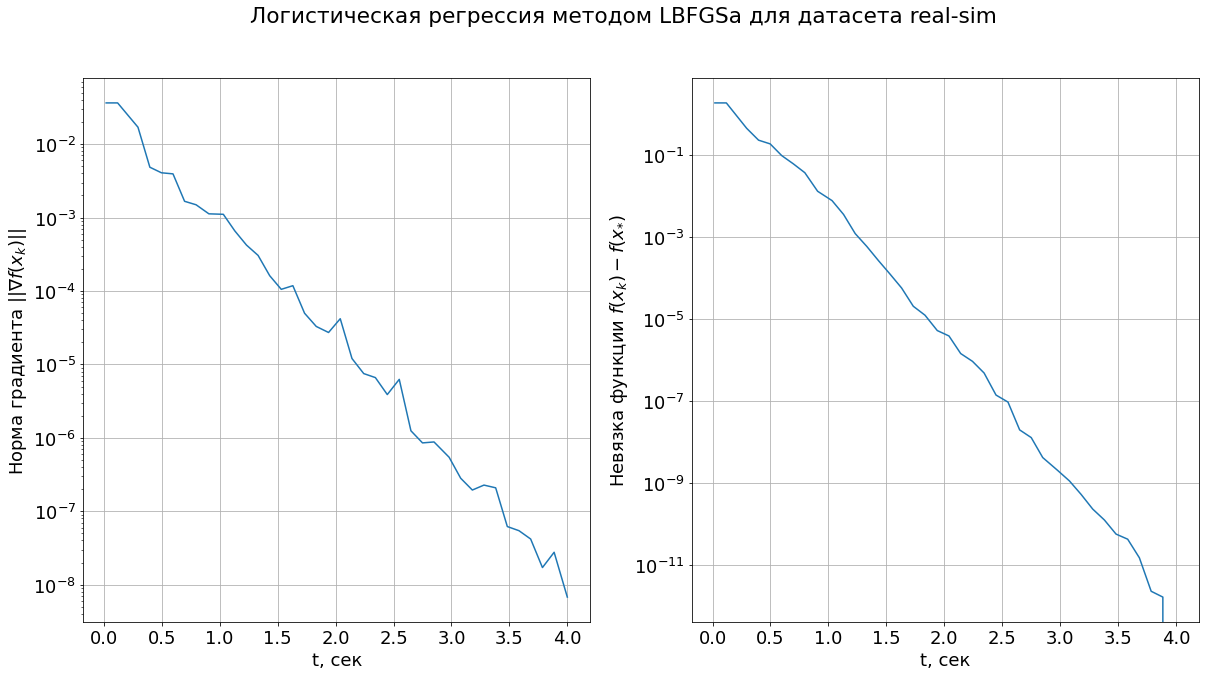

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), )

f_star_real_sim = real_sim_oracle.func(lbfgs_real_sim.hist['x_star'])
x_star_real_sim = lbfgs_real_sim.hist['x_star']

title = "Логистическая регрессия методом LBFGSа для датасета " + dataset
fig.suptitle(title)

ax1.plot(lbfgs_real_sim.hist['time'], lbfgs_real_sim.hist['grad_norm'])
ax1.grid()
ax1.semilogy()
ax1.set_xlabel("t, сек")
ax1.set_ylabel(r"Норма градиента $|| \nabla f(x_k) ||$")

ax2.plot(lbfgs_real_sim.hist['time'],  lbfgs_real_sim.hist['func'] - f_star_real_sim)
ax2.grid()
ax2.semilogy()
ax2.set_xlabel("t, сек")
ax2.set_ylabel(r"Невязка функции $f(x_k) - f(x_{*})$")

plt.show()

In [0]:
np.save("f_star_real_sim.npy", f_star_real_sim)
np.save("x_star_real_sim.npy", x_star_real_sim)

## 3. Метод Ньютона: постоянный шаг vs линейный поиск

In [25]:
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)

grad0 = a9a_oracle.grad(-np.ones(n)).T @ a9a_oracle.grad(-np.ones(n))

newton_a9a_const = Newton(oracle=a9a_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-8/grad0,
                  line_search_options=LineSearchTool(method='Constant', c=0.1)
                  )
newton_a9a_armijo = Newton(oracle=a9a_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-8/grad0,
                  line_search_options=LineSearchTool(method='Armijo')
                  )

Число функций в сумме:  32561 , размерность задачи:  123


In [26]:
%time newton_a9a_const.run(100)
print("number of iterations", len(newton_a9a_const.hist['grad_norm']))
%time newton_a9a_armijo.run(100)
print("number of iterations", len(newton_a9a_armijo.hist['grad_norm']))

CPU times: user 5.74 s, sys: 4.13 s, total: 9.87 s
Wall time: 5.04 s
number of iterations 80
CPU times: user 699 ms, sys: 506 ms, total: 1.2 s
Wall time: 622 ms
number of iterations 8


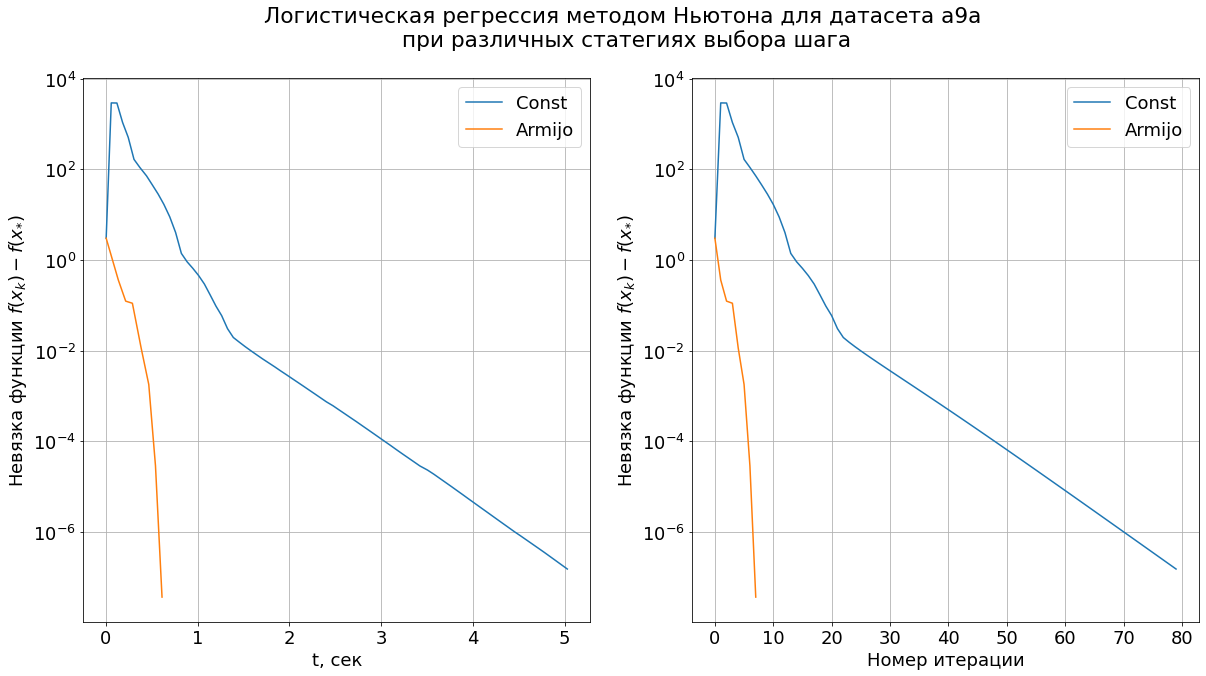

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

title = "Логистическая регрессия методом Ньютона для датасета " + dataset
title = title + "\n при различных статегиях выбора шага"
fig.suptitle(title)

ax1.plot(newton_a9a_const.hist['time'], 
         newton_a9a_const.hist['func']  - f_star_a9a,
         label = "Const")
ax1.plot(newton_a9a_armijo.hist['time'],  
         newton_a9a_armijo.hist['func'] - f_star_a9a,
         label = "Armijo")

ax2.plot(newton_a9a_const.hist['func']  - f_star_a9a,
         label = "Const")
ax2.plot(newton_a9a_armijo.hist['func'] - f_star_a9a,
         label = "Armijo")

ax1.grid()
ax1.semilogy()
ax1.legend()
ax1.set_xlabel("t, сек")
ax1.set_ylabel(r"Невязка функции $f(x_k) - f(x_{*})$")

ax2.grid()
ax2.legend()
ax2.semilogy()
ax2.set_xlabel("Номер итерации")
ax2.set_ylabel(r"Невязка функции $f(x_k) - f(x_{*})$")

plt.show()

Как видно из графиков, и по времени, и по итерациям, метод Ньютона с линейным поиском (по Армихо) гораздо быстрее метода Ньютона с постоянным шагом. Более того, в методе с постоянным шагом невязка по функции может невязка по функции может не уменьшаться. Если выбрать постоянный шаг больше определённго значения, то метод может не сойтись.

## 4. L-BFGS: зависимость от размера истории

## 4.1  Датасет $\texttt{a9a}$

In [28]:
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)

grad0 = a9a_oracle.grad(-np.ones(n)).T @ a9a_oracle.grad(-np.ones(n))

lbfgs_a9a_1 = LBFGS(oracle=a9a_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-6/grad0,
                  memory_size=1, 
                  )

lbfgs_a9a_5 = LBFGS(oracle=a9a_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-6/grad0,
                  memory_size=5,
                  )

lbfgs_a9a_10 = LBFGS(oracle=a9a_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-6/grad0,
                  memory_size=10,
                  )

lbfgs_a9a_20 = LBFGS(oracle=a9a_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-6/grad0,
                  memory_size=20,
                  )

lbfgs_a9a_50 = LBFGS(oracle=a9a_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-6/grad0,
                  memory_size=50,
                  )

lbfgs_a9a_100 = LBFGS(oracle=a9a_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-6/grad0,
                  memory_size=100,
                  )

Число функций в сумме:  32561 , размерность задачи:  123


In [29]:
%time lbfgs_a9a_1.run(5000)
print("number of iterations", len(lbfgs_a9a_1.hist['grad_norm']))
%time lbfgs_a9a_5.run(5000)
print("number of iterations", len(lbfgs_a9a_5.hist['grad_norm']))
%time lbfgs_a9a_10.run(5000)
print("number of iterations", len(lbfgs_a9a_10.hist['grad_norm']))
%time lbfgs_a9a_20.run(5000)
print("number of iterations", len(lbfgs_a9a_20.hist['grad_norm']))

%time lbfgs_a9a_50.run(5000)
print("number of iterations", len(lbfgs_a9a_50.hist['grad_norm']))
%time lbfgs_a9a_100.run(5000)
print("number of iterations", len(lbfgs_a9a_100.hist['grad_norm']))

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s
number of iterations 65
CPU times: user 1.05 s, sys: 853 µs, total: 1.06 s
Wall time: 1.06 s
number of iterations 69
CPU times: user 711 ms, sys: 39 µs, total: 711 ms
Wall time: 711 ms
number of iterations 46
CPU times: user 335 ms, sys: 1.02 ms, total: 336 ms
Wall time: 336 ms
number of iterations 22
CPU times: user 343 ms, sys: 918 µs, total: 343 ms
Wall time: 343 ms
number of iterations 22
CPU times: user 337 ms, sys: 91 µs, total: 337 ms
Wall time: 337 ms
number of iterations 22


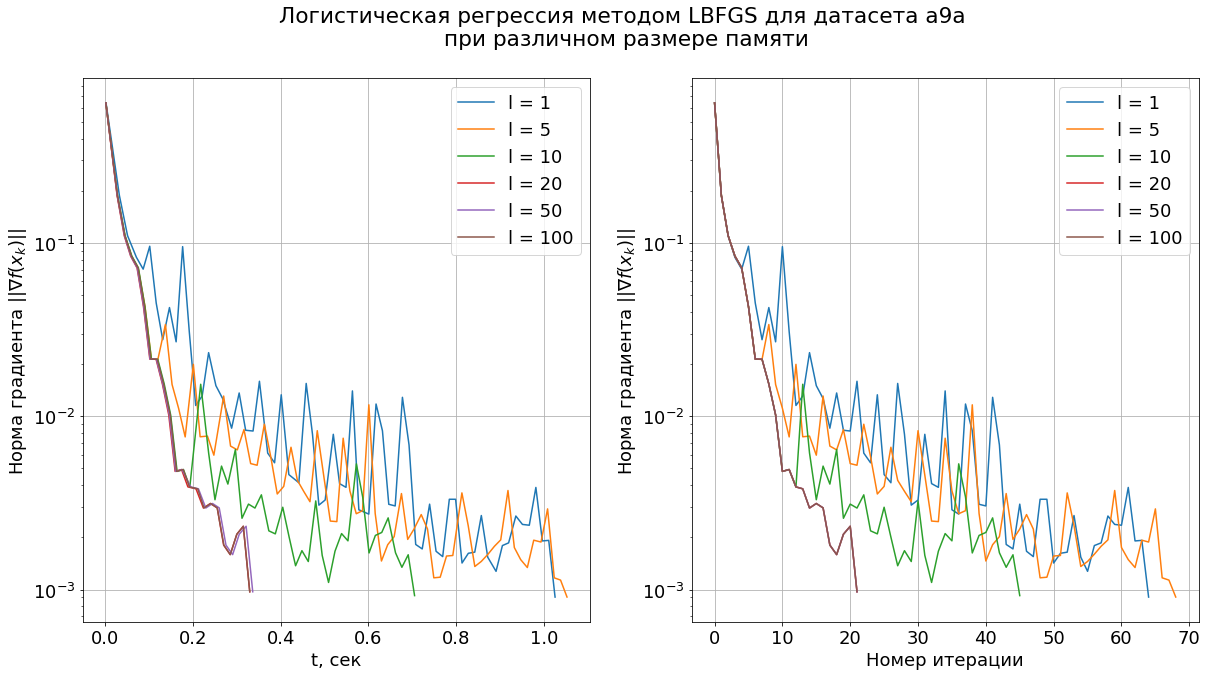

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

title = "Логистическая регрессия методом LBFGS для датасета " + dataset
title = title + "\n при различном размере памяти"
fig.suptitle(title)

ax1.plot(lbfgs_a9a_1.hist['time'],
         lbfgs_a9a_1.hist['grad_norm'],
         label = "l = 1")
ax1.plot(lbfgs_a9a_5.hist['time'],
         lbfgs_a9a_5.hist['grad_norm'],
         label = "l = 5")
ax1.plot(lbfgs_a9a_10.hist['time'],
         lbfgs_a9a_10.hist['grad_norm'],
         label = "l = 10")
ax1.plot(lbfgs_a9a_20.hist['time'],
         lbfgs_a9a_20.hist['grad_norm'],
         label = "l = 20")
ax1.plot(lbfgs_a9a_50.hist['time'],
         lbfgs_a9a_50.hist['grad_norm'],
         label = "l = 50")
ax1.plot(lbfgs_a9a_100.hist['time'],
         lbfgs_a9a_100.hist['grad_norm'],
         label = "l = 100")


ax2.plot(
         lbfgs_a9a_1.hist['grad_norm'],
         label = "l = 1")
ax2.plot(
         lbfgs_a9a_5.hist['grad_norm'],
         label = "l = 5")
ax2.plot(
         lbfgs_a9a_10.hist['grad_norm'],
         label = "l = 10")
ax2.plot(
         lbfgs_a9a_20.hist['grad_norm'],
         label = "l = 20")
ax2.plot(
         lbfgs_a9a_50.hist['grad_norm'],
         label = "l = 50")
ax2.plot(
         lbfgs_a9a_100.hist['grad_norm'],
         label = "l = 100")


ax1.grid()
ax1.semilogy()
ax1.legend()
ax1.set_xlabel("t, сек")
ax1.set_ylabel(r"Норма градиента $|| \nabla f(x_k) ||$")

ax2.grid()
ax2.legend()
ax2.semilogy()
ax2.set_xlabel("Номер итерации")
ax2.set_ylabel(r"Норма градиента $|| \nabla f(x_k) ||$")

plt.show()

С увеличением размера памяти до 20 пар качество работы метода улучшается. При дальнейшем увеличении памяти скорость по времени перестаёт расти при том, что количество итераций падает, т.е. время выполнения одной итерации с ростом памяти растёт. Таким образом, оптимальный размер на датасете `a9a` памяти равен `l = 20`.

## 4.2 Датасет $\texttt{gisette}$

In [31]:
dataset = "gisette"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)

grad0 = gisette_oracle.grad(-np.ones(n)).T @ gisette_oracle.grad(-np.ones(n))

Число функций в сумме:  6000 , размерность задачи:  5000


In [0]:
lbfgs_gisette_1 = LBFGS(oracle=gisette_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-8/grad0,
                  memory_size=1
                  )

lbfgs_gisette_5 = LBFGS(oracle=gisette_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-8/grad0,
                  memory_size=5
                  )

lbfgs_gisette_10 = LBFGS(oracle=gisette_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-8/grad0,
                  memory_size=10
                  )

lbfgs_gisette_20 = LBFGS(oracle=gisette_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-8/grad0,
                  memory_size=20
                  )

lbfgs_gisette_50 = LBFGS(oracle=gisette_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-8/grad0,
                  memory_size=50
                  )

lbfgs_gisette_100 = LBFGS(oracle=gisette_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-8/grad0,
                  memory_size=100
                  )

In [33]:
%time lbfgs_gisette_1.run(5000)
print("number of iterations", len(lbfgs_gisette_1.hist['grad_norm'])) 
%time lbfgs_gisette_5.run(5000)
print("number of iterations", len(lbfgs_gisette_5.hist['grad_norm'])) 
%time lbfgs_gisette_10.run(5000)
print("number of iterations", len(lbfgs_gisette_10.hist['grad_norm'])) 
%time lbfgs_gisette_20.run(5000)
print("number of iterations", len(lbfgs_gisette_20.hist['grad_norm'])) 
%time lbfgs_gisette_50.run(5000)
print("number of iterations", len(lbfgs_gisette_50.hist['grad_norm'])) 
%time lbfgs_gisette_100.run(5000)
print("number of iterations", len(lbfgs_gisette_100.hist['grad_norm']))

CPU times: user 4min 2s, sys: 37.7 ms, total: 4min 2s
Wall time: 4min 3s
number of iterations 427
CPU times: user 2min 28s, sys: 16.3 ms, total: 2min 28s
Wall time: 2min 28s
number of iterations 281
CPU times: user 1min 52s, sys: 14.2 ms, total: 1min 52s
Wall time: 1min 52s
number of iterations 215
CPU times: user 1min 25s, sys: 13.1 ms, total: 1min 25s
Wall time: 1min 25s
number of iterations 163
CPU times: user 58.8 s, sys: 4.02 ms, total: 58.8 s
Wall time: 58.8 s
number of iterations 112
CPU times: user 51.7 s, sys: 7.9 ms, total: 51.7 s
Wall time: 51.7 s
number of iterations 99


In [34]:
lbfgs_gisette_500 = LBFGS(oracle=gisette_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-8/grad0,
                  memory_size=500
                  )
%time lbfgs_gisette_500.run(5000)
print("number of iterations", len(lbfgs_gisette_500.hist['grad_norm']))

CPU times: user 52.6 s, sys: 5.85 ms, total: 52.6 s
Wall time: 52.8 s
number of iterations 99


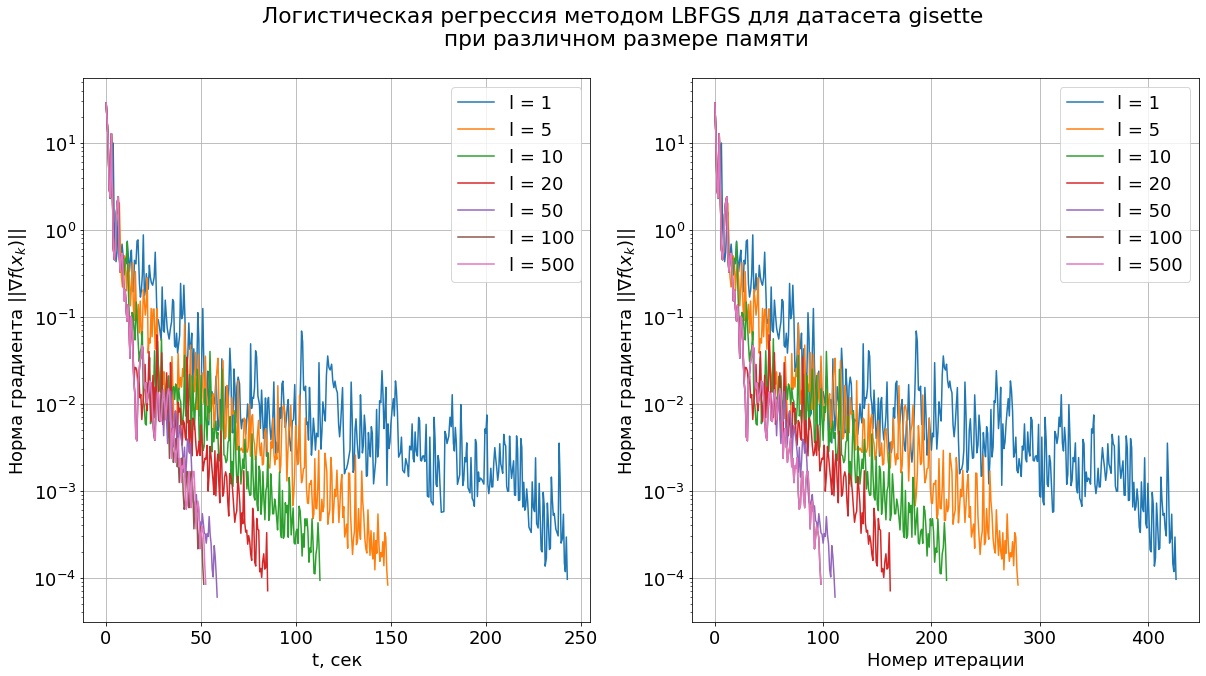

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

title = "Логистическая регрессия методом LBFGS для датасета " + dataset
title = title + "\n при различном размере памяти"
fig.suptitle(title)

ax1.plot(lbfgs_gisette_1.hist['time'],
         lbfgs_gisette_1.hist['grad_norm'],
         label = "l = 1")
ax1.plot(lbfgs_gisette_5.hist['time'],
         lbfgs_gisette_5.hist['grad_norm'],
         label = "l = 5")
ax1.plot(lbfgs_gisette_10.hist['time'],
         lbfgs_gisette_10.hist['grad_norm'],
         label = "l = 10")
ax1.plot(lbfgs_gisette_20.hist['time'],
         lbfgs_gisette_20.hist['grad_norm'],
         label = "l = 20")
ax1.plot(lbfgs_gisette_50.hist['time'],
         lbfgs_gisette_50.hist['grad_norm'],
         label = "l = 50")
ax1.plot(lbfgs_gisette_100.hist['time'],
         lbfgs_gisette_100.hist['grad_norm'],
         label = "l = 100")
ax1.plot(lbfgs_gisette_500.hist['time'],
         lbfgs_gisette_500.hist['grad_norm'],
         label = "l = 500")

ax2.plot(
         lbfgs_gisette_1.hist['grad_norm'],
         label = "l = 1")
ax2.plot(
         lbfgs_gisette_5.hist['grad_norm'],
         label = "l = 5")
ax2.plot(
         lbfgs_gisette_10.hist['grad_norm'],
         label = "l = 10")
ax2.plot(
         lbfgs_gisette_20.hist['grad_norm'],
         label = "l = 20")
ax2.plot(
         lbfgs_gisette_50.hist['grad_norm'],
         label = "l = 50")
ax2.plot(
         lbfgs_gisette_100.hist['grad_norm'],
         label = "l = 100")
ax2.plot(
         lbfgs_gisette_500.hist['grad_norm'],
         label = "l = 500")

ax1.grid()
ax1.semilogy()
ax1.legend()
ax1.set_xlabel("t, сек")
ax1.set_ylabel(r"Норма градиента $|| \nabla f(x_k) ||$")

ax2.grid()
ax2.legend()
ax2.semilogy()
ax2.set_xlabel("Номер итерации")
ax2.set_ylabel(r"Норма градиента $|| \nabla f(x_k) ||$")

plt.show()

С увеличением размера памяти до 50 пар качество работы метода улучшается. При дальнейшем увеличении памяти скорость по времени перестаёт расти при том, что количество итераций падает, т.е. время выполнения одной итерации с ростом памяти растёт. Таким образом, оптимальный размер на датасете `gisette` памяти равен `l = 50`.

## 4.3 Датасет $\texttt{real-sim}$

In [36]:
dataset = "real-sim"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)

grad0 = real_sim_oracle.grad(-np.ones(n)).T @ real_sim_oracle.grad(-np.ones(n))

Число функций в сумме:  72309 , размерность задачи:  20958


In [0]:
lbfgs_real_sim_1 = LBFGS(oracle=real_sim_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-10/grad0,
                  memory_size=1,
                  line_search_options=LineSearchTool(method='Armijo')
                  )

lbfgs_real_sim_5 = LBFGS(oracle=real_sim_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-10/grad0,
                  memory_size=5,
                  line_search_options=LineSearchTool(method='Armijo')
                  )

lbfgs_real_sim_10 = LBFGS(oracle=real_sim_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-10/grad0,
                  memory_size=10,
                  line_search_options=LineSearchTool(method='Armijo')
                  )

lbfgs_real_sim_20 = LBFGS(oracle=real_sim_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-10/grad0,
                  memory_size=20,
                  line_search_options=LineSearchTool(method='Armijo')
                  )

lbfgs_real_sim_50 = LBFGS(oracle=real_sim_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-10/grad0,
                  memory_size=50,
                  line_search_options=LineSearchTool(method='Armijo')
                  )

lbfgs_real_sim_100 = LBFGS(oracle=real_sim_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-10/grad0,
                  memory_size=100,
                  line_search_options=LineSearchTool(method='Armijo')
                  )

lbfgs_real_sim_0 = LBFGS(oracle=real_sim_oracle, 
                  x_0=-np.ones(n), 
                  tolerance=1e-10/grad0,
                  memory_size=0
                  )

In [38]:
%time lbfgs_real_sim_1.run(5000)
print("number of iterations", len(lbfgs_real_sim_1.hist['grad_norm'])) 
%time lbfgs_real_sim_5.run(5000)
print("number of iterations", len(lbfgs_real_sim_5.hist['grad_norm'])) 
%time lbfgs_real_sim_10.run(5000)
print("number of iterations", len(lbfgs_real_sim_10.hist['grad_norm'])) 
%time lbfgs_real_sim_20.run(5000)
print("number of iterations", len(lbfgs_real_sim_20.hist['grad_norm'])) 
%time lbfgs_real_sim_50.run(5000)
print("number of iterations", len(lbfgs_real_sim_50.hist['grad_norm'])) 
%time lbfgs_real_sim_100.run(5000)
print("number of iterations", len(lbfgs_real_sim_100.hist['grad_norm']))
%time lbfgs_real_sim_0.run(500)
print("number of iterations", len(lbfgs_real_sim_0.hist['grad_norm']))

CPU times: user 3.87 s, sys: 2.69 s, total: 6.56 s
Wall time: 3.36 s
number of iterations 33
CPU times: user 2.78 s, sys: 1.93 s, total: 4.72 s
Wall time: 2.39 s
number of iterations 23
CPU times: user 2.71 s, sys: 1.82 s, total: 4.52 s
Wall time: 2.29 s
number of iterations 22
CPU times: user 2.52 s, sys: 1.82 s, total: 4.34 s
Wall time: 2.2 s
number of iterations 21
CPU times: user 2.56 s, sys: 1.76 s, total: 4.32 s
Wall time: 2.21 s
number of iterations 21
CPU times: user 2.54 s, sys: 1.8 s, total: 4.34 s
Wall time: 2.19 s
number of iterations 21


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


CPU times: user 5.71 s, sys: 3.88 s, total: 9.59 s
Wall time: 4.85 s
number of iterations 36


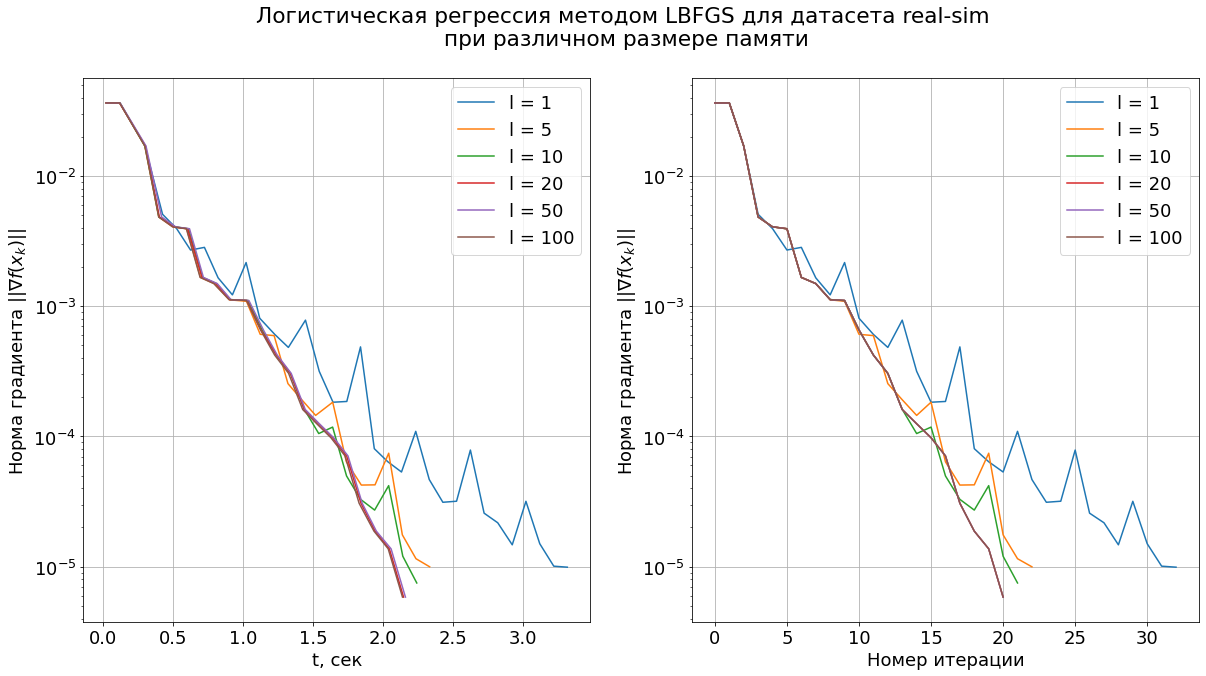

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

title = "Логистическая регрессия методом LBFGS для датасета " + dataset
title = title + "\n при различном размере памяти"
fig.suptitle(title)

ax1.plot(lbfgs_real_sim_1.hist['time'],
         lbfgs_real_sim_1.hist['grad_norm'],
         label = "l = 1")
ax1.plot(lbfgs_real_sim_5.hist['time'],
         lbfgs_real_sim_5.hist['grad_norm'],
         label = "l = 5")
ax1.plot(lbfgs_real_sim_10.hist['time'],
         lbfgs_real_sim_10.hist['grad_norm'],
         label = "l = 10")
ax1.plot(lbfgs_real_sim_20.hist['time'],
         lbfgs_real_sim_20.hist['grad_norm'],
         label = "l = 20")
ax1.plot(lbfgs_real_sim_50.hist['time'],
         lbfgs_real_sim_50.hist['grad_norm'],
         label = "l = 50")
ax1.plot(lbfgs_real_sim_100.hist['time'],
         lbfgs_real_sim_100.hist['grad_norm'],
         label = "l = 100")


ax2.plot(
         lbfgs_real_sim_1.hist['grad_norm'],
         label = "l = 1")
ax2.plot(
         lbfgs_real_sim_5.hist['grad_norm'],
         label = "l = 5")
ax2.plot(
         lbfgs_real_sim_10.hist['grad_norm'],
         label = "l = 10")
ax2.plot(
         lbfgs_real_sim_20.hist['grad_norm'],
         label = "l = 20")
ax2.plot(
         lbfgs_real_sim_50.hist['grad_norm'],
         label = "l = 50")
ax2.plot(
         lbfgs_real_sim_100.hist['grad_norm'],
         label = "l = 100")


ax1.grid()
ax1.semilogy()
ax1.legend()
ax1.set_xlabel("t, сек")
ax1.set_ylabel(r"Норма градиента $|| \nabla f(x_k) ||$")

ax2.grid()
ax2.legend()
ax2.semilogy()
ax2.set_xlabel("Номер итерации")
ax2.set_ylabel(r"Норма градиента $|| \nabla f(x_k) ||$")

plt.show()

С увеличением размера памяти до 20 пар качество работы метода улучшается. При дальнейшем увеличении памяти скорость по времени и по количеству итераций перестаёт расти. Таким образом, оптимальный размер на датасете `real-sim` памяти равен `l = 20`.

## 5. Сравнение методов

## 5.1 Датасет $\texttt{a9a}$

In [63]:
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)

grad0 = a9a_oracle.grad(-np.ones(n)).T @ a9a_oracle.grad(-np.ones(n))

gd_a9a = GradientDescent(
    oracle=a9a_oracle, 
    x_0=-np.ones(n), 
    tolerance=1e-6/grad0
)

newton_a9a = Newton(
    oracle=a9a_oracle, 
    x_0=-np.ones(n), 
    tolerance=1e-6/grad0
)

bfgs_a9a = BFGS(
    oracle=a9a_oracle, 
    x_0=-np.ones(n), 
    tolerance=1e-6/grad0
)

lbfgs_a9a = LBFGS(
    oracle=a9a_oracle, 
    x_0=-np.ones(n), 
    tolerance=1e-6/grad0,
    memory_size=20
)

Число функций в сумме:  32561 , размерность задачи:  123


In [64]:
%time gd_a9a.run(5000)
print("number of iterations", len(gd_a9a.hist['grad_norm']))
%time newton_a9a.run(5000)
print("number of iterations", len(newton_a9a.hist['grad_norm']))
%time bfgs_a9a.run(5000)
print("number of iterations", len(bfgs_a9a.hist['grad_norm']))
%time lbfgs_a9a.run(5000)
print("number of iterations", len(lbfgs_a9a.hist['grad_norm']))

CPU times: user 7.59 s, sys: 2.07 ms, total: 7.59 s
Wall time: 7.6 s
number of iterations 361
CPU times: user 657 ms, sys: 393 ms, total: 1.05 s
Wall time: 559 ms
number of iterations 8
CPU times: user 3.75 s, sys: 2.55 s, total: 6.29 s
Wall time: 3.21 s
number of iterations 137
CPU times: user 393 ms, sys: 93.8 ms, total: 486 ms
Wall time: 377 ms
number of iterations 22


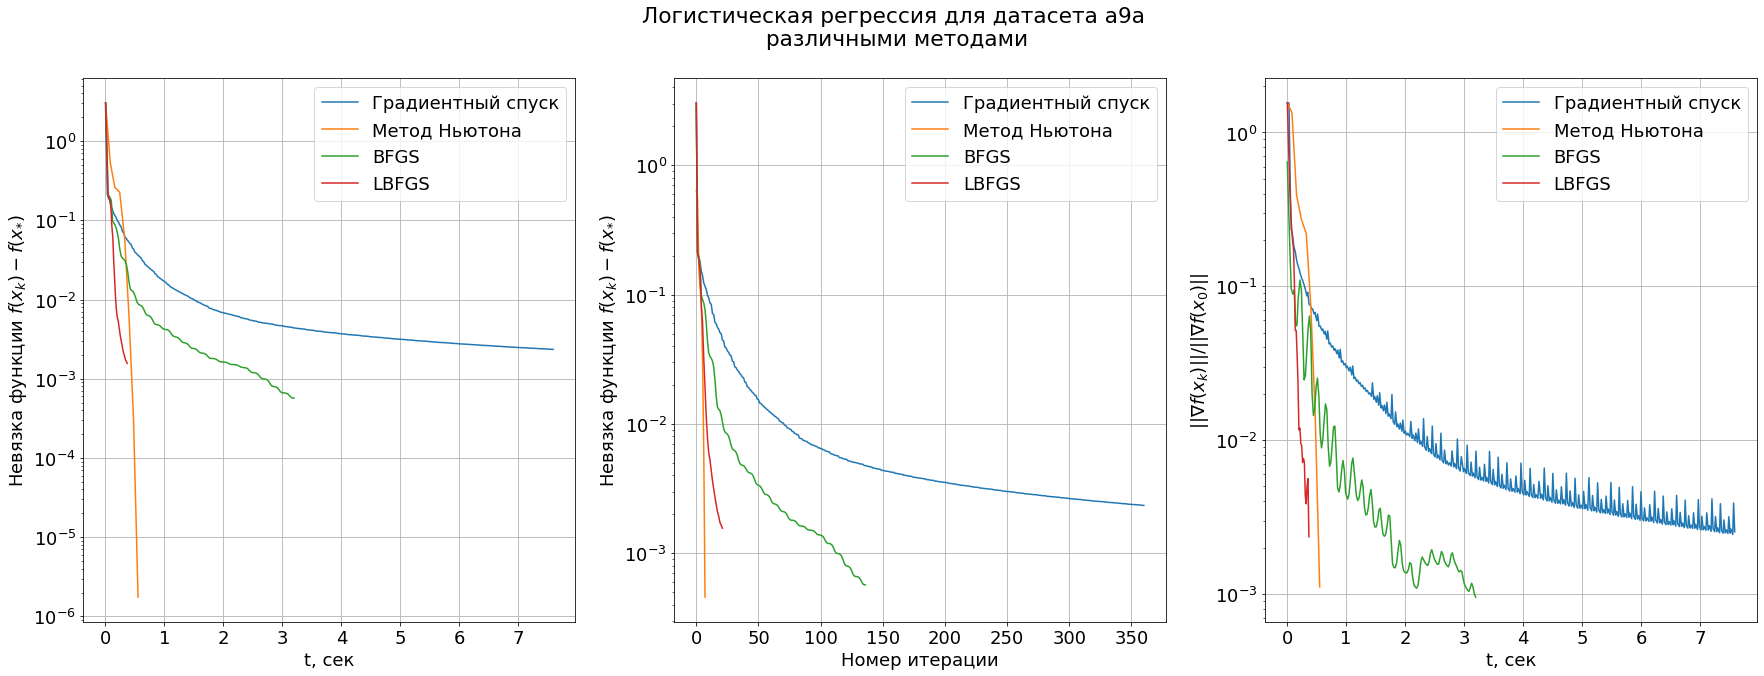

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

title = "Логистическая регрессия для датасета " + dataset
title = title + "\n различными методами"
fig.suptitle(title)

ax1.plot(gd_a9a.hist['time'],
         gd_a9a.hist['func'] - f_star_a9a,
         label = "Градиентный спуск")
ax1.plot(newton_a9a.hist['time'],
         newton_a9a.hist['func'] - f_star_a9a,
         label = "Метод Ньютона")
ax1.plot(bfgs_a9a.hist['time'],
         bfgs_a9a.hist['func'] - f_star_a9a,
         label = "BFGS")
ax1.plot(lbfgs_a9a.hist['time'],
         lbfgs_a9a.hist['func'] - f_star_a9a,
         label = "LBFGS")
ax1.grid()
ax1.semilogy()
ax1.legend()
ax1.set_xlabel("t, сек")
ax1.set_ylabel(r"Невязка функции $f(x_k) - f(x_{*})$")



ax2.plot(gd_a9a.hist['func'] - f_star_a9a,
         label = "Градиентный спуск")
ax2.plot(newton_a9a.hist['grad_norm'],
         label = "Метод Ньютона")
ax2.plot(bfgs_a9a.hist['func'] - f_star_a9a,
         label = "BFGS")
ax2.plot(lbfgs_a9a.hist['func'] - f_star_a9a,
         label = "LBFGS")

ax2.grid()
ax2.legend()
ax2.semilogy()
ax2.set_xlabel("Номер итерации")
ax2.set_ylabel(r"Невязка функции $f(x_k) - f(x_{*})$")


ax3.plot(gd_a9a.hist['time'],
         gd_a9a.hist['grad_norm']/grad0,
         label = "Градиентный спуск")
ax3.plot(newton_a9a.hist['time'],
         newton_a9a.hist['grad_norm']/grad0,
         label = "Метод Ньютона")
ax3.plot(bfgs_a9a.hist['time'],
         bfgs_a9a.hist['grad_norm'],
         label = "BFGS")
ax3.plot(lbfgs_a9a.hist['time'],
         lbfgs_a9a.hist['grad_norm']/grad0,
         label = "LBFGS")


ax3.grid()
ax3.semilogy()
ax3.legend()
ax3.set_xlabel("t, сек")
ax3.set_ylabel(r"$|| \nabla f(x_k) || / ||\nabla f(x_0)||$")

plt.show()

## 5.2 Датасет $\texttt{gisette}$

В данном пункте не исследовались метод Ньютона и BFGS из-за того, что операции перемножения матриц 5000*5000 выполняюются очень продолжительное время: запуск Ньютона выполнялся не менее получаса и не был завершён. В зависимости от размера памяти метод Ньютона и BFGS могут вызвать ошибку аллокации памяти на данном датасете.

In [43]:
dataset = "gisette"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)

grad0 = gisette_oracle.grad(-np.ones(n)).T @ gisette_oracle.grad(-np.ones(n))

gd_gisette = GradientDescent(
    oracle=gisette_oracle, 
    x_0=-np.ones(n), 
    tolerance=1e-6/grad0,
    line_search_options=LineSearchTool(method='Armijo')
)

lbfgs_gisette = LBFGS(
    oracle=gisette_oracle, 
    x_0=-np.ones(n), 
    tolerance=1e-6/grad0,
    memory_size=50,
    line_search_options=LineSearchTool(method='Armijo')
)

newton_gisette = Newton(
    oracle=gisette_oracle, 
    x_0=-np.ones(n), 
    tolerance=1e-6/grad0,
    line_search_options=LineSearchTool(method='Armijo')
)

bfgs_gisette = BFGS(
    oracle=gisette_oracle, 
    x_0=-np.ones(n), 
    tolerance=1e-6/grad0,
    line_search_options=LineSearchTool(method='Armijo')
)

Число функций в сумме:  6000 , размерность задачи:  5000


In [44]:
%time gd_gisette.run(100)
print("number of iterations", len(gd_gisette.hist['grad_norm']))

CPU times: user 1min 2s, sys: 12.2 ms, total: 1min 2s
Wall time: 1min 2s
number of iterations 101


In [45]:
%time lbfgs_gisette.run(100)
print("number of iterations", len(lbfgs_gisette.hist['grad_norm']))

CPU times: user 40.9 s, sys: 4.09 ms, total: 40.9 s
Wall time: 41 s
number of iterations 93


In [46]:
%time newton_gisette.run(100)
print("number of iterations", len(newton_gisette.hist['grad_norm']))

KeyboardInterrupt: ignored

In [48]:
%time bfgs_gisette.run(100)
print("number of iterations", len(bfgs_gisette.hist['grad_norm']))

KeyboardInterrupt: ignored

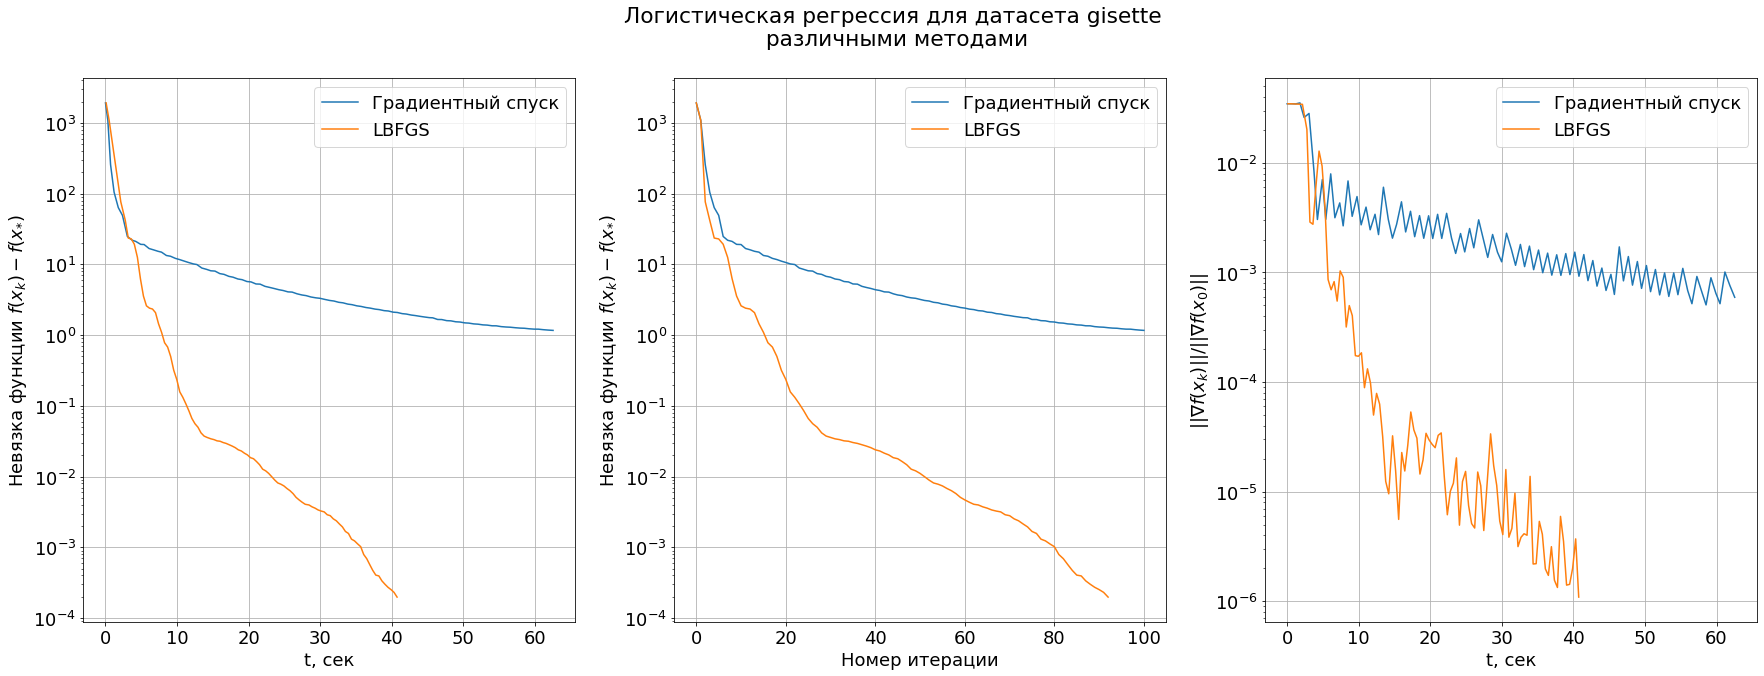

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

title = "Логистическая регрессия для датасета " + dataset
title = title + "\n различными методами"
fig.suptitle(title)

ax1.plot(gd_gisette.hist['time'],
         gd_gisette.hist['func'] - f_star_gisette,
         label = "Градиентный спуск")
ax1.plot(lbfgs_gisette.hist['time'],
         lbfgs_gisette.hist['func'] - f_star_gisette,
         label = "LBFGS")
ax1.grid()
ax1.semilogy()
ax1.legend()
ax1.set_xlabel("t, сек")
ax1.set_ylabel(r"Невязка функции $f(x_k) - f(x_{*})$")



ax2.plot(gd_gisette.hist['func'] - f_star_gisette,
         label = "Градиентный спуск")
ax2.plot(lbfgs_gisette.hist['func'] - f_star_gisette,
         label = "LBFGS")

ax2.grid()
ax2.legend()
ax2.semilogy()
ax2.set_xlabel("Номер итерации")
ax2.set_ylabel(r"Невязка функции $f(x_k) - f(x_{*})$")


ax3.plot(gd_gisette.hist['time'],
         gd_gisette.hist['grad_norm']/grad0,
         label = "Градиентный спуск")
ax3.plot(lbfgs_gisette.hist['time'],
         lbfgs_gisette.hist['grad_norm']/grad0,
         label = "LBFGS")


ax3.grid()
ax3.semilogy()
ax3.legend()
ax3.set_xlabel("t, сек")
ax3.set_ylabel(r"$|| \nabla f(x_k) || / ||\nabla f(x_0)||$")

plt.show()

## 5.3 Датасет $\texttt{real-sim}$

В данном пункте не исследовались усечённый метод Ньютона и BFGS из-за ошибки аллокации памяти. Указанная ошибка была ожидаема: размерность задачи превышает 10000 и для метода Ньютона и BFGS требуется хранение и обновление матрицы размера порядка 100 млн чисел с плавающей точкой.

In [50]:
dataset = "real-sim"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)

grad0 = real_sim_oracle.grad(-np.ones(n)).T @ real_sim_oracle.grad(-np.ones(n))

gd_real_sim = GradientDescent(
    oracle=real_sim_oracle, 
    x_0=-np.ones(n), 
    tolerance=1e-6/grad0,
    line_search_options=LineSearchTool(method='Armijo')
)

lbfgs_real_sim = LBFGS(
    oracle=real_sim_oracle, 
    x_0=-np.ones(n), 
    tolerance=1e-6/grad0,
    memory_size=20,
    line_search_options=LineSearchTool(method='Armijo')
)


# newton_real_sim = Newton(
#     oracle=real_sim_oracle, 
#     x_0=-np.ones(n), 
#     tolerance=1e-6/grad0,
#     line_search_options=LineSearchTool(method='Armijo')
# )

# bfgs_real_sim = BFGS(
#     oracle=real_simoracle, 
#     x_0=-np.ones(n), 
#     tolerance=1e-6/grad0,
#     line_search_options=LineSearchTool(method='Armijo')
# )

Число функций в сумме:  72309 , размерность задачи:  20958


In [51]:
%time gd_real_sim.run(500)
print("number of iterations", len(gd_real_sim.hist['grad_norm']))

CPU times: user 52 s, sys: 36.6 s, total: 1min 28s
Wall time: 44.8 s
number of iterations 501


In [52]:
%time lbfgs_real_sim.run(500)
print("number of iterations", len(lbfgs_real_sim.hist['grad_norm']))

CPU times: user 1.39 s, sys: 940 ms, total: 2.33 s
Wall time: 1.18 s
number of iterations 11


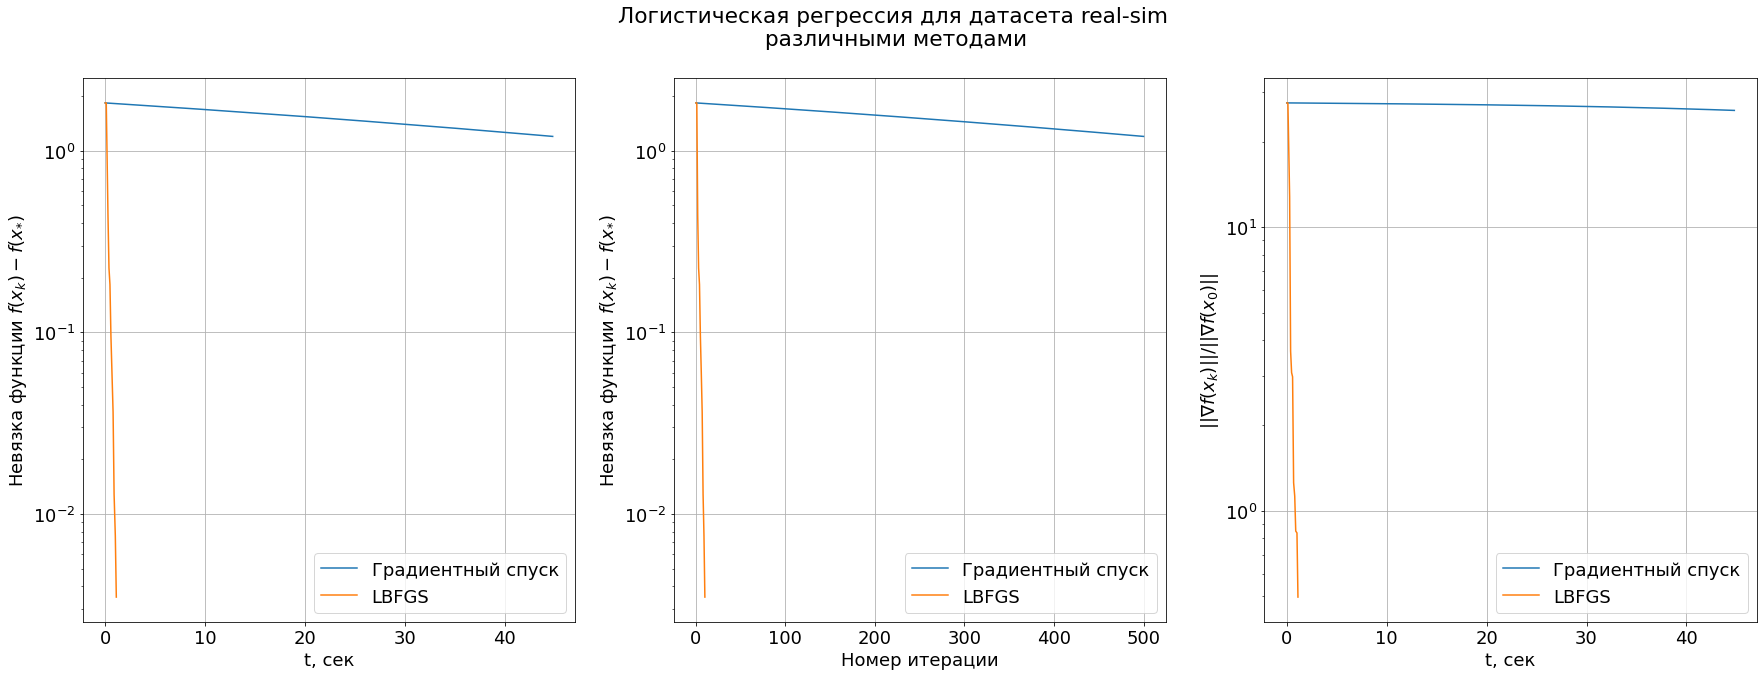

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

title = "Логистическая регрессия для датасета " + dataset
title = title + "\n различными методами"
fig.suptitle(title)

ax1.plot(gd_real_sim.hist['time'],
         gd_real_sim.hist['func'] - f_star_real_sim,
         label = "Градиентный спуск")
ax1.plot(lbfgs_real_sim.hist['time'],
         lbfgs_real_sim.hist['func'] - f_star_real_sim,
         label = "LBFGS")
ax1.grid()
ax1.semilogy()
ax1.legend()
ax1.set_xlabel("t, сек")
ax1.set_ylabel(r"Невязка функции $f(x_k) - f(x_{*})$")



ax2.plot(gd_real_sim.hist['func'] - f_star_real_sim,
         label = "Градиентный спуск")
ax2.plot(lbfgs_real_sim.hist['func'] - f_star_real_sim,
         label = "LBFGS")

ax2.grid()
ax2.legend()
ax2.semilogy()
ax2.set_xlabel("Номер итерации")
ax2.set_ylabel(r"Невязка функции $f(x_k) - f(x_{*})$")


ax3.plot(gd_real_sim.hist['time'],
         gd_real_sim.hist['grad_norm']/grad0,
         label = "Градиентный спуск")
ax3.plot(lbfgs_real_sim.hist['time'],
         lbfgs_real_sim.hist['grad_norm']/grad0,
         label = "LBFGS")


ax3.grid()
ax3.semilogy()
ax3.legend()
ax3.set_xlabel("t, сек")
ax3.set_ylabel(r"$|| \nabla f(x_k) || / ||\nabla f(x_0)||$")

plt.show()

## Выводы по результатам сравнения методов на всех датасетах

  1) Наилучший метод на $\texttt{a9a}$ - Ньютон, на $\texttt{gisette}$ и $\texttt{𝚛𝚎𝚊𝚕-𝚜𝚒𝚖}$ - `LBFGS`. Следует отметить, что `LBFGS` показывает результаты на $\texttt{a9a}$, сравнимые с методом Ньютона, при значительно меньшем использовании памяти и даже немного выигрывает по времени испольнения, что ожидаемо, т.к. в `LBFGS` не требуется умножать или обновлять квадратные матрицы больших размеров;
  
  2) Метод Ньютона наилучшим образом показал себя на $\texttt{a9a}$, поскольку размерность $\texttt{a9a}$ значительно меньше, чем других датасетов. 